# Imports

In [1]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import xgboost as xgb
import warnings

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
warnings.filterwarnings('ignore')

# Configs

In [3]:
INPUT_PATH = '/Users/maedeh/Desktop/demand_project/demand_project/shoofer-demand-prediction/data/features_df_phase2.parquet'
Ridge_PATH = '/Users/maedeh/Desktop/demand_project/demand_project/shoofer-demand-prediction/data/Ridge_feature_predictions_phase2.parquet'
XGB_ridge_PATH = '/Users/maedeh/Desktop/demand_project/demand_project/shoofer-demand-prediction/data/XGB_ridge_predictions_phase2.parquet'
XGB_PATH = '/Users/maedeh/Desktop/demand_project/demand_project/shoofer-demand-prediction/data/XGB_predictions_phase2.parquet'


FEATURE_LIST = ['zone',

                'day_of_week',
                'day_of_month',
    
                'max_previous_week_interval',
    
                'max_previous_7exact_interval',
    
                'previous_day_9interval',
                'previous_day_10interval',
                'previous_day_17interval',

                'diff_previous_2day_interval',

                'diff_previous_2day_previous_interval',
    
                'previous_day_interval',
                'previous_2day_interval',
                'previous_3day_interval',
                'previous_4day_interval',
                'previous_5day_interval',
                'previous_6day_interval',
                'previous_week_interval',
                'previous_8day_interval',
                'previous_9day_interval',
                'previous_10day_interval',
                'previous_11day_interval',
                'previous_12day_interval',
                'previous_13day_interval',
                'previous_2week_interval'
               ]


TEST_START_DATE = '2023-04-1'
NUM_INTERVAL_PER_DAY = 8
HIGH_DEMAND_NUMS = 55
MID_DEMAND_NUMS = 157
sort_method = 'mean'

AUTO_TUNE = False
add_ridge_feature = False

# Data preparation


## Load Data

In [4]:
def load_data(INPUT_PATH):
    features_df = pd.read_parquet(INPUT_PATH, engine='pyarrow')
    return features_df

In [5]:
features_df = load_data(INPUT_PATH)

In [6]:
print(f'features dataframe shape : {features_df.shape}')
features_df.head()

features dataframe shape : (251520, 7)


,Location,Date,Hour_interval,Demand,previous_day_interval,previous_week_interval,previous_2week_interval
0,1,2023-01-01,0,0.0,NaN,NaN,NaN
1,1,2023-01-01,3,1.0,NaN,NaN,NaN
2,1,2023-01-01,6,1.0,NaN,NaN,NaN
3,1,2023-01-01,9,1.0,NaN,NaN,NaN
4,1,2023-01-01,12,13.0,NaN,NaN,NaN


In [7]:
ridge_df = pd.read_parquet(Ridge_PATH)

In [8]:
print(f'rides dataframe shape : {ridge_df.shape}')
ridge_df.head()

rides dataframe shape : (222176, 4)


,Location,Date,Hour_interval,Predicted_demand
0,1,2023-01-15,0,0.044613
1,1,2023-01-15,3,0.622963
2,1,2023-01-15,6,2.138966
3,1,2023-01-15,9,1.236023
4,1,2023-01-15,12,5.688196


## Add feature

In [9]:
def add_feature(dataset, lag_num):
    
    for i in range(1,lag_num):
        if i not in(1,7):
            dataset[f'previous_{i}day_interval'] = dataset.groupby('Location')['Demand'].shift(i*NUM_INTERVAL_PER_DAY)

    
    dataset['day_of_week'] = dataset['Date'].dt.dayofweek
    dataset['day_of_month'] = dataset['Date'].dt.day
    dataset['time'] = dataset['Hour_interval']
    dataset['zone'] = dataset['Location']

    
    dataset['max_previous_week_interval'] = dataset.groupby('Location')['Demand'].rolling(window = 7*NUM_INTERVAL_PER_DAY).max().reset_index(drop=True)
    dataset['max_previous_2week_interval'] = dataset.groupby('Location')['Demand'].rolling(window = 14*NUM_INTERVAL_PER_DAY).max().reset_index(drop=True)

    
    df = dataset.sort_values(['Location','Hour_interval','Date'])[['Location','Hour_interval','Date','Demand']]
    df['max_previous_7exact_interval'] = dataset.groupby(['Location','Hour_interval'])['Demand'].rolling(window = 7).max().values
    dataset['max_previous_7exact_interval'] = df.sort_values(['Location', 'Date','Hour_interval'])['max_previous_7exact_interval']
    df['max_previous_14exact_interval'] = dataset.groupby(['Location','Hour_interval'])['Demand'].rolling(window = 14).max().values
    dataset['max_previous_14exact_interval'] = df.sort_values(['Location', 'Date','Hour_interval'])['max_previous_14exact_interval']

    
    dataset['previous_day_9interval'] = dataset.groupby('Location')['Demand'].shift(NUM_INTERVAL_PER_DAY+1)
    dataset['previous_day_10interval'] = dataset.groupby('Location')['Demand'].shift(NUM_INTERVAL_PER_DAY+2)
    dataset['previous_day_17interval'] = dataset.groupby('Location')['Demand'].shift(NUM_INTERVAL_PER_DAY+17)

    
    dataset['diff_previous_2day_previous_interval'] = dataset['previous_day_17interval']-dataset['previous_day_9interval']

    
    dataset['diff_previous_2day_interval'] = dataset['previous_day_interval']-dataset['previous_2day_interval']
    dataset['diff_previous_2week_interval'] = dataset['previous_week_interval']-dataset['previous_2week_interval']

    
    sort_index = dataset.groupby(['Location','Hour_interval'])['Demand'].aggregate([sort_method]).sort_values(sort_method, ascending=False).reset_index()
    sorted_index = sort_index[['Location', 'Hour_interval']]
    high_demand_df = dataset.merge(sorted_index[:HIGH_DEMAND_NUMS], on=['Location','Hour_interval'])
    mid_demand_df = dataset.merge(sorted_index[HIGH_DEMAND_NUMS:HIGH_DEMAND_NUMS+MID_DEMAND_NUMS], on=['Location','Hour_interval'])
    low_demand_df = dataset.merge(sorted_index[HIGH_DEMAND_NUMS+MID_DEMAND_NUMS:], on=['Location','Hour_interval'])
    high_demand_df['group_max'] = high_demand_df['Demand'].max()
    high_demand_df['group_min'] = high_demand_df['Demand'].min()
    mid_demand_df['group_max'] = mid_demand_df['Demand'].max()
    mid_demand_df['group_min'] = mid_demand_df['Demand'].min()
    low_demand_df['group_max'] = low_demand_df['Demand'].max()
    low_demand_df['group_min'] = low_demand_df['Demand'].min()
    dataset = pd.concat([high_demand_df, mid_demand_df, low_demand_df]).sort_values(['Location','Date','Hour_interval'])
    
    return dataset



In [10]:
new_features_df = add_feature(features_df, lag_num = 14)
print(f'new features dataframe shape : {new_features_df.shape}')
new_features_df.head()

new features dataframe shape : (251520, 34)


,Location,Date,Hour_interval,Demand,previous_day_interval,previous_week_interval,previous_2week_interval,previous_2day_interval,previous_3day_interval,previous_4day_interval,...,max_previous_7exact_interval,max_previous_14exact_interval,previous_day_9interval,previous_day_10interval,previous_day_17interval,diff_previous_2day_previous_interval,diff_previous_2day_interval,diff_previous_2week_interval,group_max,group_min
0,1,2023-01-01,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1030.0,0.0
120,1,2023-01-01,3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1030.0,0.0
240,1,2023-01-01,6,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1030.0,0.0
360,1,2023-01-01,9,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1030.0,0.0
480,1,2023-01-01,12,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1030.0,0.0


In [11]:
def feature_selection(dataset, FEATURE_LIST):
    
    dataset = dataset[['Location','Date','Hour_interval','Demand']+FEATURE_LIST]
    dataset.dropna(inplace = True)
    
    return dataset

In [12]:
selected_features_df = feature_selection(new_features_df, FEATURE_LIST)
print(f'features dataframe shape : {selected_features_df.shape}')
selected_features_df.head()

features dataframe shape : (222176, 28)


,Location,Date,Hour_interval,Demand,zone,day_of_week,day_of_month,max_previous_week_interval,max_previous_7exact_interval,previous_day_9interval,...,previous_5day_interval,previous_6day_interval,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval
14,1,2023-01-15,0,0.0,1,6,15,14.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
134,1,2023-01-15,3,2.0,1,6,15,14.0,2.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,3.0,1.0
254,1,2023-01-15,6,1.0,1,6,15,14.0,2.0,0.0,...,0.0,2.0,3.0,1.0,0.0,2.0,2.0,2.0,4.0,1.0
374,1,2023-01-15,9,0.0,1,6,15,14.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,2.0,0.0,2.0,4.0,1.0
494,1,2023-01-15,12,8.0,1,6,15,14.0,8.0,1.0,...,1.0,1.0,2.0,1.0,3.0,4.0,3.0,7.0,11.0,13.0


In [13]:
def join_ridge_feature(dataset, ridge_df, FEATURE_LIST):

    dataset = dataset.merge(ridge_df, how='outer', on = ['Location','Date','Hour_interval'])
    FEATURE_LIST.append('Predicted_demand')
    
    return dataset, FEATURE_LIST

In [14]:
if add_ridge_feature:
    selected_features_df, FEATURE_LIST = join_ridge_feature(selected_features_df, ridge_df, FEATURE_LIST)
    print(f'final features dataframe shape : {selected_features_df.shape}')
selected_features_df.head()

,Location,Date,Hour_interval,Demand,zone,day_of_week,day_of_month,max_previous_week_interval,max_previous_7exact_interval,previous_day_9interval,...,previous_5day_interval,previous_6day_interval,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval
14,1,2023-01-15,0,0.0,1,6,15,14.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
134,1,2023-01-15,3,2.0,1,6,15,14.0,2.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,3.0,1.0
254,1,2023-01-15,6,1.0,1,6,15,14.0,2.0,0.0,...,0.0,2.0,3.0,1.0,0.0,2.0,2.0,2.0,4.0,1.0
374,1,2023-01-15,9,0.0,1,6,15,14.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,2.0,0.0,2.0,4.0,1.0
494,1,2023-01-15,12,8.0,1,6,15,14.0,8.0,1.0,...,1.0,1.0,2.0,1.0,3.0,4.0,3.0,7.0,11.0,13.0


## Split Train and Test Data

In [15]:
def train_test_splitting(dataset, TEST_START_DATE):
    
    train_df = dataset[dataset['Date'] < TEST_START_DATE]
    test_df = dataset[dataset['Date'] >= TEST_START_DATE]

    return train_df, test_df

In [16]:
train_df, test_df = train_test_splitting(selected_features_df, TEST_START_DATE)

In [17]:
print(f'train dataframe shape : {train_df.shape}')
train_df.head()

train dataframe shape : (159296, 28)


,Location,Date,Hour_interval,Demand,zone,day_of_week,day_of_month,max_previous_week_interval,max_previous_7exact_interval,previous_day_9interval,...,previous_5day_interval,previous_6day_interval,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval
14,1,2023-01-15,0,0.0,1,6,15,14.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
134,1,2023-01-15,3,2.0,1,6,15,14.0,2.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,3.0,1.0
254,1,2023-01-15,6,1.0,1,6,15,14.0,2.0,0.0,...,0.0,2.0,3.0,1.0,0.0,2.0,2.0,2.0,4.0,1.0
374,1,2023-01-15,9,0.0,1,6,15,14.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,2.0,0.0,2.0,4.0,1.0
494,1,2023-01-15,12,8.0,1,6,15,14.0,8.0,1.0,...,1.0,1.0,2.0,1.0,3.0,4.0,3.0,7.0,11.0,13.0


In [18]:
print(f'test dataframe shape : {test_df.shape}')
test_df.head()

test dataframe shape : (62880, 28)


,Location,Date,Hour_interval,Demand,zone,day_of_week,day_of_month,max_previous_week_interval,max_previous_7exact_interval,previous_day_9interval,...,previous_5day_interval,previous_6day_interval,previous_week_interval,previous_8day_interval,previous_9day_interval,previous_10day_interval,previous_11day_interval,previous_12day_interval,previous_13day_interval,previous_2week_interval
90,1,2023-04-01,0,0.0,1,5,1,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
210,1,2023-04-01,3,1.0,1,5,1,6.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0
330,1,2023-04-01,6,1.0,1,5,1,6.0,3.0,0.0,...,0.0,0.0,3.0,0.0,5.0,2.0,0.0,1.0,1.0,7.0
450,1,2023-04-01,9,0.0,1,5,1,6.0,3.0,0.0,...,0.0,0.0,2.0,1.0,1.0,3.0,1.0,1.0,2.0,2.0
570,1,2023-04-01,12,1.0,1,5,1,6.0,5.0,2.0,...,2.0,5.0,3.0,2.0,4.0,0.0,0.0,3.0,9.0,2.0


# Model Training

## **Gradient Boosting Regressor**

### Model Tuning

In [19]:
def grid_search(model, test_parameters, train_data, feature_list, cv = None):
    gs = GridSearchCV(
        estimator = model, 
        param_grid = test_parameters, 
        scoring = 'neg_root_mean_squared_error', 
        cv = cv, 
        n_jobs = -1
        )
    
    gs.fit(train_data[feature_list], train_data['Demand'])
    return gs.best_params_, gs.best_score_

In [20]:
if AUTO_TUNE:
    params_test = {'learning_rate':[0.006, 0.01, 0.02], 
                'subsample':[0.9], 
                'colsample_bytree':[0.9], 
                'max_depth':[7,8], 
                'gamma':[10],
                'n_estimators':[1700,2000]
                }
    params = {"objective": "reg:squarederror"}

    best_params, best_score = grid_search(
        model = xgb.XGBRegressor(**params), 
        test_parameters = params_test,
        train_data = train_df, 
        feature_list = FEATURE_LIST, 
        cv = 3
        )
    
    print(best_params, best_score)
else:
    best_params = {'colsample_bytree': 0.9, 
                   'gamma': 10, 
                   'learning_rate': 0.02, 
                   'max_depth': 7, 
                   'subsample': 0.9, 
                   'n_estimators': 2000
                   }

### Prediction

In [21]:
def model_predict(model, train_data, test_data, feature_list):

    model.fit(train_data[feature_list], train_data['Demand'])
    
    train_predict_df  = model.predict(train_data[feature_list])
    test_predict_df  = model.predict(test_data[feature_list])

    return train_predict_df, test_predict_df

In [22]:
model = xgb.XGBRegressor(**best_params)
train_prediction_df, test_prediction_df = model_predict(model, train_df, test_df, FEATURE_LIST)

### Visualization

In [23]:
def prediction_visualization(train_data, test_data, train_prediction_df, test_prediction_df):

    predicted_train_df = train_data
    predicted_test_df = test_data
    predicted_train_df['Predicted'] = train_prediction_df
    predicted_test_df['Predicted'] = test_prediction_df
    
    train_data = train_data.groupby(['Date','Hour_interval'])['Demand'].sum()
    test_data = test_data.groupby(['Date','Hour_interval'])['Demand'].sum()
    predicted_train_df = predicted_train_df.groupby(['Date','Hour_interval'])['Predicted'].sum()
    predicted_test_df = predicted_test_df.groupby(['Date','Hour_interval'])['Predicted'].sum()

    plt.figure(figsize=(30,10))
    plt.title('Train', fontsize = 30)
    plt.plot(range(1,len(train_data)+1), train_data)
    plt.plot(range(1,len(train_data)+1), predicted_train_df)
    plt.xlabel('time interval', fontsize = 15)
    plt.legend(["Real Value", "Predicted"], loc ="lower right", fontsize = 15)
    plt.show()

    plt.figure(figsize=(30,10))
    plt.title('Test', fontsize = 30)
    plt.plot(range(1,len(test_data)+1), test_data)
    plt.plot(range(1,len(test_data)+1), predicted_test_df)
    plt.xlabel('time interval', fontsize = 15)
    plt.legend(["Real Value", "Predicted"], loc ="lower right", fontsize = 15)
    plt.show()

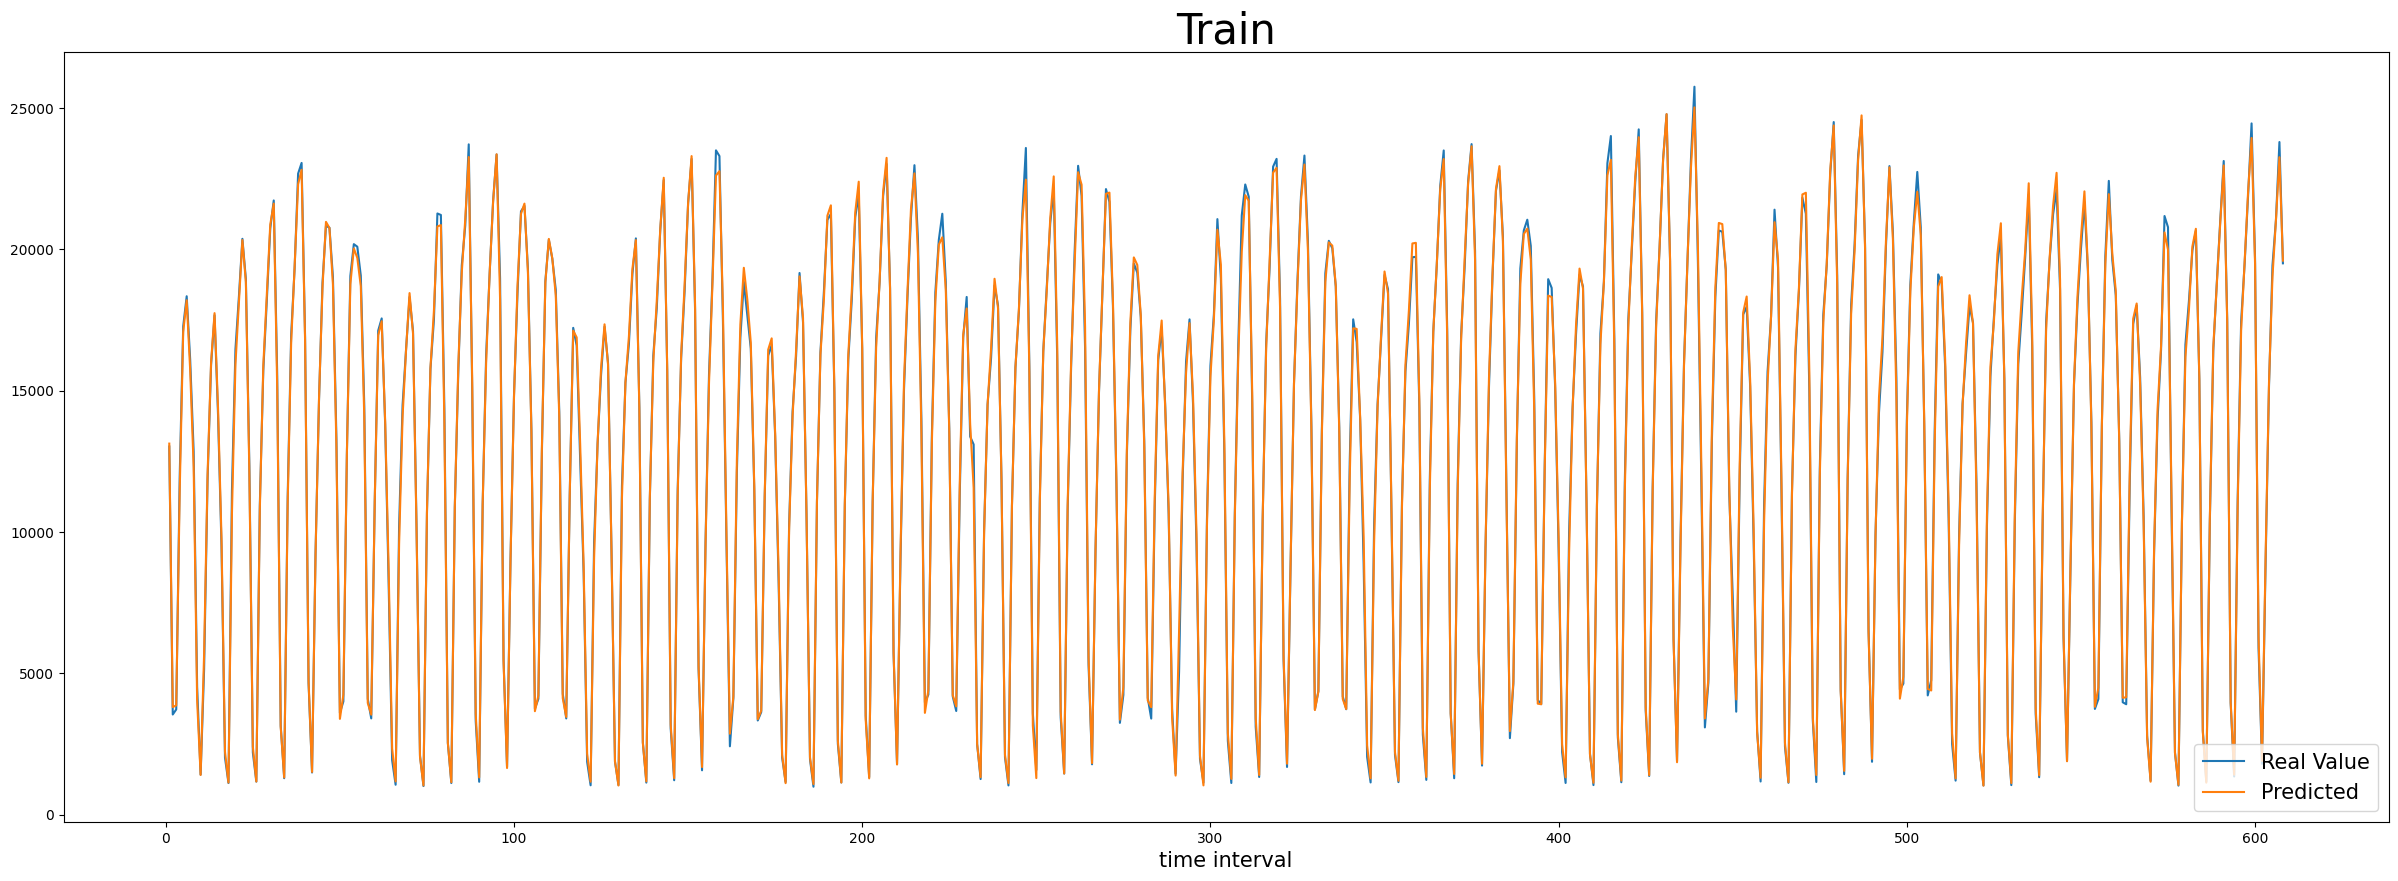

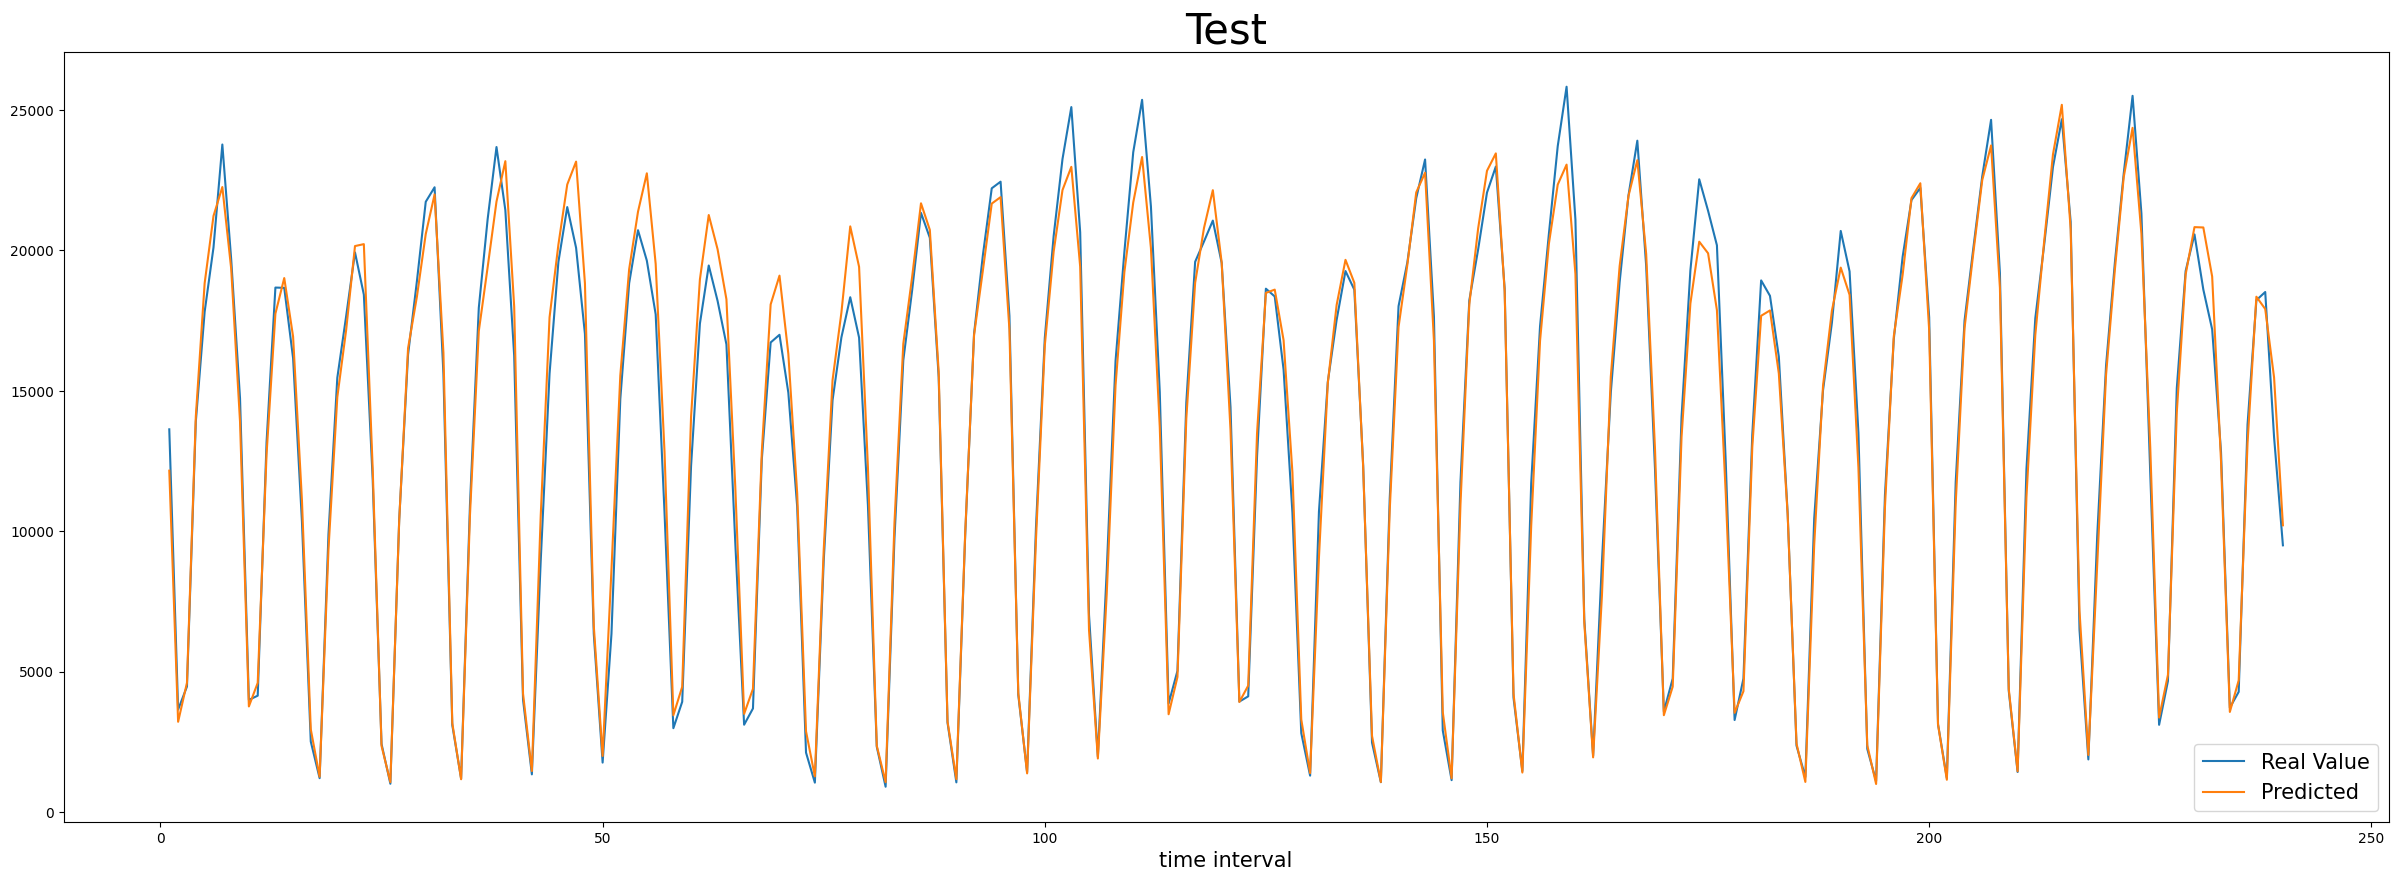

In [24]:
prediction_visualization(train_df, test_df, train_prediction_df, test_prediction_df)

### Evaluation

In [25]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [26]:
def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred))
    smape = np.mean(numerator / denominator)
    return smape * 100

In [27]:
def evaluation(model_name, train_df, test_df, train_prediction_df, test_prediction_df):
    print(f'{model_name} train scores:')


    evaluate(mean_absolute_error, 'MAE', train_df['Demand'], train_prediction_df)
    evaluate(mean_squared_error, 'MSE', train_df['Demand'], train_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', train_df['Demand'], train_prediction_df)
    evaluate(smape, 'smape', train_df['Demand'], train_prediction_df)

    print(f'{model_name} test scores:')

    evaluate(mean_absolute_error, 'MAE', test_df['Demand'], test_prediction_df)
    evaluate(mean_squared_error, 'MSE', test_df['Demand'], test_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', test_df['Demand'], test_prediction_df)
    evaluate(smape, 'smape', test_df['Demand'], test_prediction_df)


In [28]:
evaluation('XGB', train_df, test_df, train_prediction_df, test_prediction_df)

XGB train scores:
MAE : 2.699025027163703
MSE : 41.690445767002046
MAPE : 761326886921399.9
smape : 58.61560447845234
XGB test scores:
MAE : 5.8414764555717955
MSE : 369.9646867633859
MAPE : 780144990377134.6
smape : 57.87282967259038


### Feature Importance and SHAPE

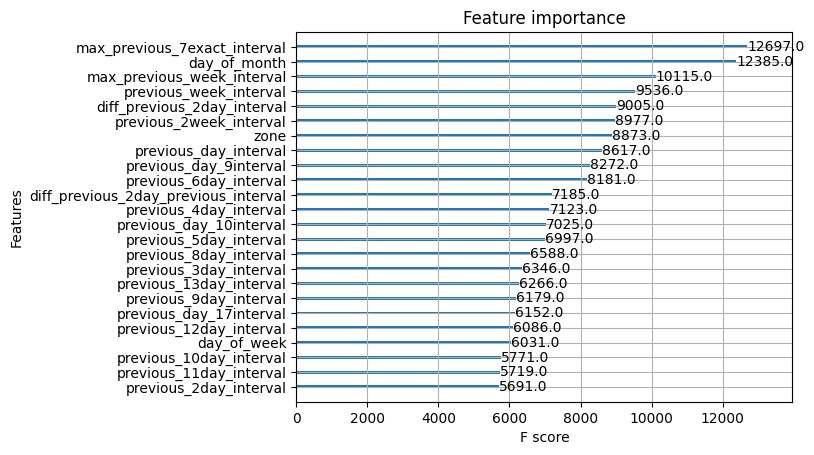

In [29]:
xgb.plot_importance(model)
plt.show()

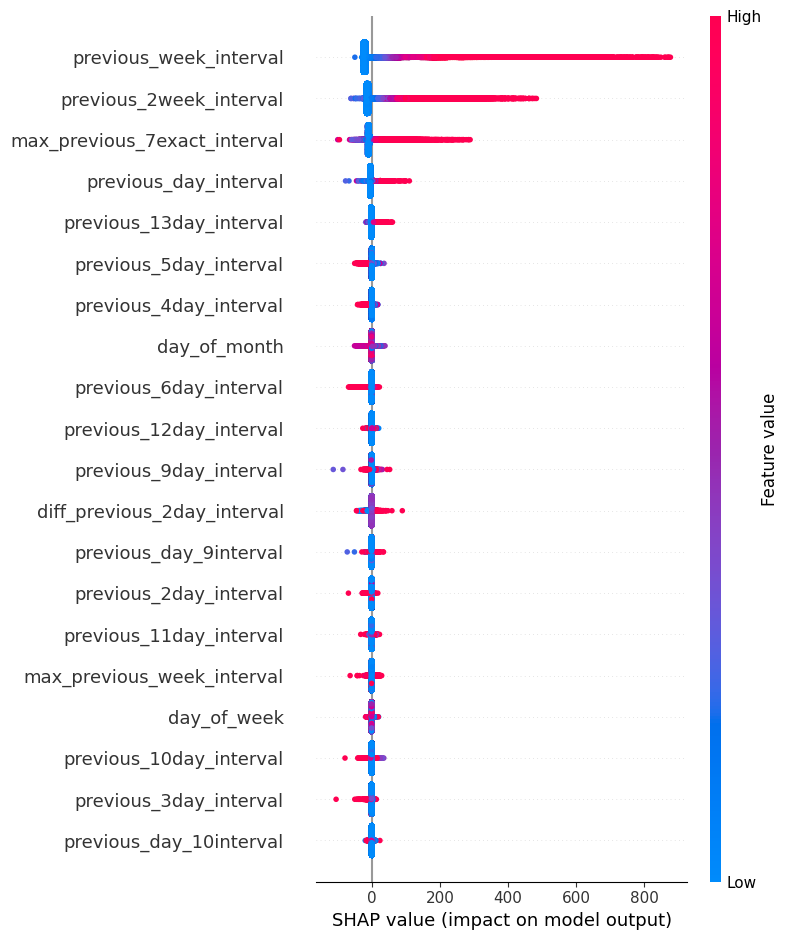

In [30]:
dtrain_reg = xgb.DMatrix(train_df[FEATURE_LIST].values, train_df['Demand'].values, enable_categorical=True)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dtrain_reg)
shap.summary_plot(shap_values, train_df[FEATURE_LIST])

# File Saving

In [31]:
def save_predictions(dataset, path):
    dataset.to_parquet(path, index=False)

In [32]:
def prediction_labeling(pred_df, labeled_df):
    labeled_df.reset_index(inplace = True)
    labeled_prediction_df = labeled_df[['Location', 'Date', 'Hour_interval']]
    labeled_prediction_df['Predicted_demand'] = pred_df
    return labeled_prediction_df

In [33]:
labeled_prediction_df = prediction_labeling(test_prediction_df, test_df)

In [34]:
print(f'labeled prediction dataframe shape : {labeled_prediction_df.shape}')
labeled_prediction_df.head()

labeled prediction dataframe shape : (62880, 4)


,Location,Date,Hour_interval,Predicted_demand
0,1,2023-04-01,0,0.120632
1,1,2023-04-01,3,0.397139
2,1,2023-04-01,6,1.658671
3,1,2023-04-01,9,1.411157
4,1,2023-04-01,12,2.838161


In [35]:
if add_ridge_feature:
    OUTPUT_PATH = XGB_ridge_PATH
else:
    OUTPUT_PATH = XGB_PATH


save_predictions(labeled_prediction_df, OUTPUT_PATH)